In [3]:
import pandas as pd
import numpy as np
import math
import datetime
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [4]:
warnings.filterwarnings("ignore")
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 5)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Reading Data

In [5]:
df_train = pd.read_excel('Data_Train.xlsx')
ntrain = df_train.shape[0]
df_train.shape

(12690, 9)

In [6]:
df_train.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


In [199]:
df_val = pd.read_excel('Data_Test.xlsx')
df_val.shape

(4231, 8)

In [200]:
df_val.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,CASUAL DINING,4085,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),Noida,Sector 18,4.3,564 votes
1,QUICK BITES,12680,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),Mumbai,Grant Road,4.2,61 votes
2,CASUAL DINING,1411,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),Mumbai,Marine Lines,3.8,350 votes
3,None,204,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",Faridabad,NIT,3.8,1445 votes
4,QUICK BITES,13453,"South Indian, Kerala",11am – 10pm (Mon-Sun),Kochi,Kaloor,3.6,23 votes


# Exploratory Data Analysis
- I started with exploring value_counts() for each feature and checking how the costs are distributed across different values of each of these features. Later, I experimented with clubbing similar values together and checking how it affected performance of my ensemble tree-based algorithms. 
- I tried experimenting with TIME column and extracting important features such as opening time, closing time, closing days, etc. I probably underexplored this information (I'll really appreciate if you can suggest how I could have achieved the same results in a more efficient way or any other time-related features that I missed). 
- For values in CITY column which also contained locality, I copied such values to LOCALITY to and cleaned them to keep only relevant ones. 

In [201]:
y = df_train['COST'].values
df = pd.concat([df_train.drop(columns=['COST']), df_val])
df.shape

(16921, 8)

In [202]:
df.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes


(array([1.464e+04, 0.000e+00, 6.880e+02, 0.000e+00, 1.550e+02, 0.000e+00,
        4.700e+01, 0.000e+00, 0.000e+00, 2.100e+01, 0.000e+00, 1.600e+01,
        0.000e+00, 5.000e+00, 0.000e+00, 2.000e+00]),
 array([1.    , 1.4375, 1.875 , 2.3125, 2.75  , 3.1875, 3.625 , 4.0625,
        4.5   , 4.9375, 5.375 , 5.8125, 6.25  , 6.6875, 7.125 , 7.5625,
        8.    ]),
 <a list of 16 Patch objects>)

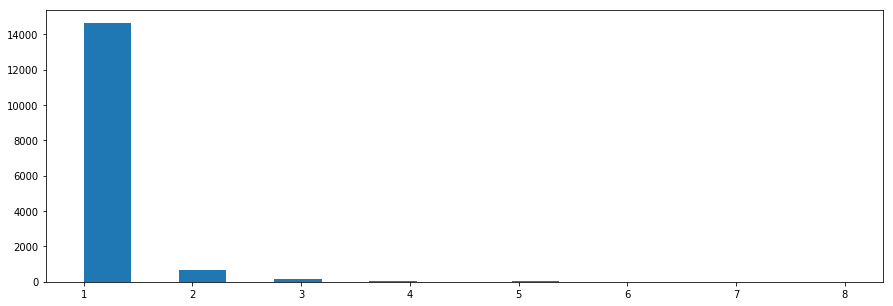

In [203]:
plt.hist(df.RESTAURANT_ID.value_counts(), bins=16)

In [204]:
#checking restaurants which have multiple RESTAURANT_ID
res_grouby = df.groupby(['RESTAURANT_ID'])['TIME'].size()
res_list = res_grouby[res_grouby>3].sort_values(ascending=False).index.tolist()
for res in res_list:
    df[res] = 0
    df.loc[df['RESTAURANT_ID']==res, res] = 1

In [205]:
title_list = df['TITLE'].str.split(',')

In [206]:
from collections import Counter
title_counter = Counter(([a for b in title_list.tolist() for a in b]))
title_counter

Counter({'CASUAL DINING': 5865,
         'BAR': 900,
         'QUICK BITES': 6144,
         'DESSERT PARLOR': 795,
         'CAFÉ': 1140,
         'MICROBREWERY': 98,
         'BEVERAGE SHOP': 331,
         'IRANI CAFE': 5,
         'BAKERY': 707,
         'None': 1287,
         'PUB': 189,
         'FINE DINING': 468,
         'SWEET SHOP': 218,
         'LOUNGE': 263,
         'FOOD COURT': 144,
         'FOOD TRUCK': 39,
         'MESS': 68,
         'KIOSK': 80,
         'CLUB': 39,
         'CONFECTIONERY': 6,
         'DHABA': 61,
         'MEAT SHOP': 4,
         'COCKTAIL BAR': 7,
         'PAAN SHOP': 6,
         'BHOJANALYA': 1})

In [207]:
title_list_set = set([a for b in title_list.tolist() for a in b])
for title in title_list_set:
    print(title, ": ", df_train[df_train['TITLE'].str.contains(title)]['COST'].mean())

BAKERY :  366.4454887218045
SWEET SHOP :  288.7096774193548
FOOD COURT :  423.8888888888889
MICROBREWERY :  1672.5352112676057
PUB :  1508.695652173913
MESS :  255.28301886792454
BHOJANALYA :  nan
FINE DINING :  2908.7988826815645
KIOSK :  225.83333333333334
COCKTAIL BAR :  2550.0
None :  415.55333998005983
CASUAL DINING :  865.0671386161224
QUICK BITES :  348.1128751631144
MEAT SHOP :  483.3333333333333
DHABA :  387.1111111111111
FOOD TRUCK :  273.5483870967742
PAAN SHOP :  120.0
CONFECTIONERY :  360.0
BAR :  1494.2572674418604
LOUNGE :  1785.0746268656717
IRANI CAFE :  1400.0
CAFÉ :  707.1174377224199
CLUB :  2303.5714285714284
DESSERT PARLOR :  330.8766233766234
BEVERAGE SHOP :  265.7429718875502


In [208]:
#Merging similar titles to reduce title variations
df['TITLE'] = df['TITLE'].str.replace('PUB','BAR')
df['TITLE'] = df['TITLE'].str.replace('MICROBREWERY','BAR')
df['TITLE'] = df['TITLE'].str.replace('IRANI CAFE','BAR')
df['TITLE'] = df['TITLE'].str.replace('BHOJANALYA','MESS')
df['TITLE'] = df['TITLE'].str.replace('CONFECTIONERY','BAKERY')
df['TITLE'] = df['TITLE'].str.replace('DESSERT PARLOR','BAKERY')
df['TITLE'] = df['TITLE'].str.replace('SWEET SHOP','BEVERAGE SHOP')
df['TITLE'] = df['TITLE'].str.replace('FOOD COURT','QUICK BITES')
df['TITLE'] = df['TITLE'].str.replace('KIOSK','MESS')
df['TITLE'] = df['TITLE'].str.replace('CLUB','FINE DINING')
df['TITLE'] = df['TITLE'].str.replace('COCKTAIL BAR','FINE DINING')
df['TITLE'] = df['TITLE'].str.replace('DHABA','QUICK BITES')
df['TITLE'] = df['TITLE'].str.replace('PAAN SHOP','None')
df['TITLE'] = df['TITLE'].str.replace('MEAT SHOP','QUICK BITES')
df['TITLE'] = df['TITLE'].str.replace('FOOD TRUCK','QUICK BITES')
df['TITLE'] = df['TITLE'].str.replace('LOUNGE','BAR')

In [209]:
title_list = df['TITLE'].str.split(',')
title_counter = Counter(([a for b in title_list.tolist() for a in b]))
title_counter

Counter({'CASUAL DINING': 5865,
         'BAR': 1455,
         'QUICK BITES': 6392,
         'BAKERY': 1508,
         'CAFÉ': 1140,
         'BEVERAGE SHOP': 549,
         'None': 1293,
         'FINE DINING': 514,
         'MESS': 149})

In [210]:
# Creating one-hot encoding manually. Similar function is used to create one-hot encoded columns for 
# CUISINES, CITY and LOCALITY
for title in title_counter.keys():
    df[title] = 0
    df.loc[df['TITLE'].str.contains(title), title] = 1

In [211]:
df['CUISINES'] = df['CUISINES'].str.lower()
df['CUISINES'] = df['CUISINES'].str.replace(' ','')
dftemp = df[:ntrain]

In [212]:
cuisines_list = df['CUISINES'].str.split(',')
cuisines_counter = Counter(([a for b in cuisines_list.tolist() for a in b]))
cuisines_counter

Counter({'malwani': 74,
         'goan': 42,
         'northindian': 7222,
         'asian': 600,
         'modernindian': 87,
         'japanese': 190,
         'chinese': 5849,
         'biryani': 1683,
         'hyderabadi': 180,
         'tibetan': 65,
         'desserts': 1507,
         'seafood': 768,
         'cafe': 1115,
         'pizza': 700,
         'burger': 493,
         'barfood': 45,
         'southindian': 3034,
         'fastfood': 2866,
         'beverages': 1286,
         'arabian': 534,
         'mughlai': 1029,
         'maharashtrian': 95,
         'parsi': 28,
         'thai': 427,
         'bakery': 874,
         'momos': 493,
         'continental': 2095,
         'european': 326,
         'rolls': 348,
         'andhra': 327,
         'italian': 1536,
         'bbq': 215,
         'fingerfood': 374,
         'tea': 79,
         'american': 388,
         'healthyfood': 290,
         'coffee': 63,
         'indonesian': 23,
         'korean': 46,
         'nepa

In [213]:
cuisines_list_set = set([a for b in cuisines_list.tolist() for a in b])
for cuisine in cuisines_list_set:
    print(cuisine, ": ", df_train[dftemp['CUISINES'].str.contains(cuisine)]['COST'].mean())

 :  655.2522458628841
mediterranean :  1721.8954248366013
asian :  1460.972850678733
panini :  450.0
bengali :  632.7380952380952
lebanese :  734.1935483870968
mangalorean :  892.96875
bihari :  419.2307692307692
peruvian :  2850.0
hotpot :  700.0
northindian :  745.8497120564741
burmese :  962.0
pizza :  725.1953125
oriental :  3000.0
pakistani :  1500.0
british :  1150.0
beverages :  455.5739400206825
coffeeandtea :  425.0
paan :  120.0
belgian :  1050.0
icecream :  306.1624649859944
mughlai :  783.8239159001314
mongolian :  900.0
northeastern :  738.2352941176471
fishandchips :  nan
african :  900.0
sandwich :  435.02024291497975
spanish :  1865.7894736842106
hawaiian :  nan
gujarati :  812.7906976744187
russian :  1200.0
indian :  694.0690603514133
afghan :  691.6666666666666
jewish :  700.0
wraps :  496.875
portuguese :  1333.3333333333333
modernindian :  1630.4347826086957
dumplings :  950.0
bohri :  466.6666666666667
southamerican :  1650.0
bbq :  908.2857142857143
german :  170

In [214]:
#Merging similar cuisines to reduce variations
df['CUISINES'] = df['CUISINES'].str.replace('bihari','regional_400') #450
df['CUISINES'] = df['CUISINES'].str.replace('bohri','regional_400')
df['CUISINES'] = df['CUISINES'].str.replace('tamil','regional_400')
df['CUISINES'] = df['CUISINES'].str.replace('oriya','regional_400')
df['CUISINES'] = df['CUISINES'].str.replace('kerala','regional_400')

df['CUISINES'] = df['CUISINES'].str.replace('panini','sandwich') #450
df['CUISINES'] = df['CUISINES'].str.replace('charcoalchicken','sandwich')

df['CUISINES'] = df['CUISINES'].str.replace('bengali','regional_650') #650
df['CUISINES'] = df['CUISINES'].str.replace('chettinad','regional_650')
df['CUISINES'] = df['CUISINES'].str.replace('maharashtrian','regional_650')
df['CUISINES'] = df['CUISINES'].str.replace('nepalese','regional_650')
df['CUISINES'] = df['CUISINES'].str.replace('andhra','regional_650')

df['CUISINES'] = df['CUISINES'].str.replace('hotpot','regional_650') #700
df['CUISINES'] = df['CUISINES'].str.replace('pizza','regional_650')
df['CUISINES'] = df['CUISINES'].str.replace('chinese','regional_650')
df['CUISINES'] = df['CUISINES'].str.replace('vegan','regional_650')
df['CUISINES'] = df['CUISINES'].str.replace('cafe','regional_650')
df['CUISINES'] = df['CUISINES'].str.replace('cafefood','regional_650')
df['CUISINES'] = df['CUISINES'].str.replace('healthyfood','')
df['CUISINES'] = df['CUISINES'].str.replace('lebanese','kebab') #750
df['CUISINES'] = df['CUISINES'].str.replace('turkish','kebab')

df['CUISINES'] = df['CUISINES'].str.replace('mangalorean','seafood') #900
df['CUISINES'] = df['CUISINES'].str.replace('konkan','seafood')
df['CUISINES'] = df['CUISINES'].str.replace('thai','seafood')
df['CUISINES'] = df['CUISINES'].str.replace('parsi','seafood')
df['CUISINES'] = df['CUISINES'].str.replace('srilankan','seafood')
 
df['CUISINES'] = df['CUISINES'].str.replace('korean','asian') #1450
df['CUISINES'] = df['CUISINES'].str.replace('singaporean','asian')
df['CUISINES'] = df['CUISINES'].str.replace('sushi','asian')
df['CUISINES'] = df['CUISINES'].str.replace('vietnamese','asian')
df['CUISINES'] = df['CUISINES'].str.replace('malaysian','asian')
df['CUISINES'] = df['CUISINES'].str.replace('indonesian','asian')
df['CUISINES'] = df['CUISINES'].str.replace('modernindian','asian')

df['CUISINES'] = df['CUISINES'].str.replace('mediterranean','european') #1750
df['CUISINES'] = df['CUISINES'].str.replace('spanish','european') 
df['CUISINES'] = df['CUISINES'].str.replace('barfood','european') 
df['CUISINES'] = df['CUISINES'].str.replace('fingerfood','european') 
df['CUISINES'] = df['CUISINES'].str.replace('japanese','european')
df['CUISINES'] = df['CUISINES'].str.replace('greek','european')
df['CUISINES'] = df['CUISINES'].str.replace('drinksonly','european')

df['CUISINES'] = df['CUISINES'].str.replace('peruvian','european') #2700
df['CUISINES'] = df['CUISINES'].str.replace('cantonese','european') 
df['CUISINES'] = df['CUISINES'].str.replace('egyptian','european')
df['CUISINES'] = df['CUISINES'].str.replace('moroccan','european')
df['CUISINES'] = df['CUISINES'].str.replace('irish','european')

df['CUISINES'] = df['CUISINES'].str.replace('Malwani','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('BubbleTea','Desserts')
df['CUISINES'] = df['CUISINES'].str.replace('CoffeeandTea','Beverages')
df['CUISINES'] = df['CUISINES'].str.replace('Hyderabadi','Biryani')
df['CUISINES'] = df['CUISINES'].str.replace('Goan','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Thai','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Japanese','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('BarFood','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Juices','Beverages')
df['CUISINES'] = df['CUISINES'].str.replace('Bakery','Desserts')
#df['CUISINES'] = df['CUISINES'].str.replace('Continental,','Continental')
df['CUISINES'] = df['CUISINES'].str.replace('Tibetan','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('ModernIndian','European')
df['CUISINES'] = df['CUISINES'].str.replace('Pizza','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Burger','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Maharashtrian','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Parsi','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Thai','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Momos','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Rolls','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Italian','European')
df['CUISINES'] = df['CUISINES'].str.replace('Andhra','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('BBQ','European')
df['CUISINES'] = df['CUISINES'].str.replace('FingerFood','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Tea','Beverages')
df['CUISINES'] = df['CUISINES'].str.replace('American','European')
df['CUISINES'] = df['CUISINES'].str.replace('HealthyFood','Salad')
df['CUISINES'] = df['CUISINES'].str.replace('Coffee','Beverages')
df['CUISINES'] = df['CUISINES'].str.replace('Indonesian','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Korean','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Nepalese','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Mexican','European')
df['CUISINES'] = df['CUISINES'].str.replace('IceCream','Desserts')
df['CUISINES'] = df['CUISINES'].str.replace('Kerala','Regional')
#df['CUISINES'] = df['CUISINES'].str.replace('Indian','North Indian')
df['CUISINES'] = df['CUISINES'].str.replace('Mithai','Desserts')
df['CUISINES'] = df['CUISINES'].str.replace('StreetFood','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Malaysian','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Vietnamese','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Arabian','European')
df['CUISINES'] = df['CUISINES'].str.replace('Iranian','European')
df['CUISINES'] = df['CUISINES'].str.replace('Kebab','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Sandwich','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Mediterranean','European')
df['CUISINES'] = df['CUISINES'].str.replace('Gujarati','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Rajasthani','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Tex-Mex','European')
df['CUISINES'] = df['CUISINES'].str.replace('RoastChicken','European')
df['CUISINES'] = df['CUISINES'].str.replace('Chettinad','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('NorthEastern','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Lebanese','European')
df['CUISINES'] = df['CUISINES'].str.replace('Grill','European')
#df['CUISINES'] = df['CUISINES'].str.replace('Biryani,','Biryani')
df['CUISINES'] = df['CUISINES'].str.replace('Bihari','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Bengali','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Lucknowi','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Awadhi','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Steak','European')
df['CUISINES'] = df['CUISINES'].str.replace('French','European')
df['CUISINES'] = df['CUISINES'].str.replace('Portuguese','European')
df['CUISINES'] = df['CUISINES'].str.replace('Wraps','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('SriLankan','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Oriya','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Ethiopian','European')
df['CUISINES'] = df['CUISINES'].str.replace('Konkan','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Sushi','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Spanish','European')
df['CUISINES'] = df['CUISINES'].str.replace('Russian','European')
df['CUISINES'] = df['CUISINES'].str.replace('Mangalorean','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Turkish','European')
#df['CUISINES'] = df['CUISINES'].str.replace(',','North Indian')
#df['CUISINES'] = df['CUISINES'].str.replace('European,','European')
#df['CUISINES'] = df['CUISINES'].str.replace('Salad,','Salad')
#df['CUISINES'] = df['CUISINES'].str.replace('Healthy Food,','Salad')
#df['CUISINES'] = df['CUISINES'].str.replace('Desserts,','Desserts')
df['CUISINES'] = df['CUISINES'].str.replace('Naga','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Singaporean','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('German','European')
df['CUISINES'] = df['CUISINES'].str.replace('MiddleEastern','European')
df['CUISINES'] = df['CUISINES'].str.replace('Sindhi','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('Cantonese','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('HotPot','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Kashmiri','Regional')
df['CUISINES'] = df['CUISINES'].str.replace('British','European')

In [215]:
df['CUISINES'] = df['CUISINES'].str.replace('PanAsian','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Satay','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Dumplings','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('RawMeats','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('DrinksOnly','Beverages')
df['CUISINES'] = df['CUISINES'].str.replace('CafeFood','Cafe')
df['CUISINES'] = df['CUISINES'].str.replace('Hotdogs','FastFood')
df['CUISINES'] = df['CUISINES'].str.replace('Burmese','Asian')
df['CUISINES'] = df['CUISINES'].str.replace('Afghan','European')
df['CUISINES'] = df['CUISINES'].str.replace('SouthEuropean','European')

In [216]:
regional_replace = ['Tamil','Assamese','Bohri','Mishti']
for cuisine in regional_replace:
    df['CUISINES'] = df['CUISINES'].str.replace(cuisine,'Regional')

In [217]:
cuisine_df = pd.DataFrame.from_dict(cuisines_counter, orient='index').reset_index()
cuisine_df.columns = ['cuisine','counts']
european_replace = list(cuisine_df[cuisine_df.counts<=10]['cuisine'])
for cuisine in european_replace:
    df['CUISINES'] = df['CUISINES'].str.replace(cuisine,'European')

In [218]:
df['CUISINES'] = df['CUISINES'].str.replace('NorthIndian','Northindian')
df['CUISINES'] = df['CUISINES'].str.replace('SouthIndian','Southindian')
df['CUISINES'] = df['CUISINES'].str.replace('Indian','Northindian')

In [219]:
cuisines_list = df['CUISINES'].str.split(',')
cuisines_counter = Counter(([a for b in cuisines_list.tolist() for a in b]))
del cuisines_counter['']
cuisines_counter

Counter({'malwani': 74,
         'goan': 42,
         'northindian': 7222,
         'asian': 600,
         'modernindian': 87,
         'japanese': 190,
         'chinese': 5849,
         'biryani': 1683,
         'hyderabadi': 180,
         'tibetan': 65,
         'desserts': 1507,
         'seafood': 768,
         'cafe': 1115,
         'pizza': 700,
         'burger': 493,
         'barfood': 45,
         'southindian': 3034,
         'fastfood': 2866,
         'beverages': 1286,
         'arabian': 534,
         'mughlai': 1029,
         'maharashtrian': 95,
         'parsi': 28,
         'thai': 427,
         'bakery': 874,
         'momos': 493,
         'continental': 2095,
         'european': 326,
         'rolls': 348,
         'andhra': 327,
         'italian': 1536,
         'bbq': 215,
         'fingerfood': 374,
         'tea': 79,
         'american': 388,
         'healthyfood': 290,
         'coffee': 63,
         'indonesian': 23,
         'korean': 46,
         'nepa

In [220]:
for cuisine in cuisines_counter.keys():
    df[cuisine] = 0
    df.loc[df['CUISINES'].str.contains(cuisine), cuisine] = 1

In [221]:
df.TIME = df.TIME.str.lower()
df.TIME = df.TIME.str.replace(" ","")
df.TIME = df.TIME.str.replace("–",'-')

In [222]:
df['all_days'] = 0
df.loc[df.TIME.str.contains(r'(\(mon\-sun\))'),'all_days'] = 1
df.TIME = df.TIME.str.replace("\(mon-sun\)","")

In [223]:
df['closed_weekend'] = 0
df.loc[df.TIME.str.contains("closed\(sun\)"),"closed_weekend"] = 1
df.loc[df.TIME.str.contains("closed\(sat\)"),"closed_weekend"] = 1
df.TIME = df.TIME.str.replace("closed\(sun\)","")
df.TIME = df.TIME.str.replace("closed\(sat\)","")

In [224]:
df['closed_weekday'] = 0
df.loc[df.TIME.str.contains("closed\(mon\)"),"closed_weekday"] = 1
df.loc[df.TIME.str.contains("closed\(tue\)"),"closed_weekday"] = 1
df.loc[df.TIME.str.contains("closed\(wed\)"),"closed_weekday"] = 1
df.TIME = df.TIME.str.replace("closed\(mon\)","")
df.TIME = df.TIME.str.replace("closed\(tue\)","")
df.TIME = df.TIME.str.replace("closed\(wed\)","")

In [225]:
#df.TIME = df.TIME.str.replace(",",' ')
df.TIME = df.TIME.str.replace("(",' ')

In [226]:
df.TIME = df.TIME.str.strip()
df.TIME = df.TIME.str.split(" ").str.get(0).str.lstrip(',')

In [227]:
df.TIME = df.TIME.str.replace("-"," ")
df.TIME = df.TIME.str.replace(","," ")

In [228]:
df.TIME = df.TIME.str.replace("12noon","12:01")
df.TIME = df.TIME.str.replace("12midnight","00:01")
df.TIME[df.TIME.str.contains("24hours")] = "00:01 23:59"
df.TIME[df.TIME.str.contains("notavailable")] = "11am 11pm"
df.TIME[df.TIME.str.contains("mon")] = "11am 11pm"
df.TIME[df.TIME.str.contains("closed")] = "9am 9am"
df.TIME = df.TIME.str.replace(".","")
df.TIME[df.TIME == ""] = "11am 11pm"

In [229]:
from dateutil.parser import parse
a = df.TIME.str.split(' ', expand=True)
a.columns = ["1","2","3","4","5","6"]
a['1'] = a['1'].apply(lambda x: parse(x))
a['2'] = a['2'].apply(lambda x: parse(x))
a['3'] = a['3'].apply(lambda x: parse(x) if x is not None else x)
a['4'][a['4']==""] = None
a['6'][a['6']==""] = None
a['4'] = a['4'].apply(lambda x: parse(x) if x is not None else x)
a['5'] = a['5'].apply(lambda x: parse(x) if x is not None else x)
a['6'] = a['6'].apply(lambda x: parse(x) if x is not None else x)

In [230]:
a['2'] = a.apply(lambda row: row['2']+datetime.timedelta(days=1) if (row['2']-row['1']) < datetime.timedelta(minutes=1) else row['2'], axis=1)
a['3'] = a.apply(lambda row: row['3']+datetime.timedelta(days=1) if (row['3']-row['1']) < datetime.timedelta(minutes=1) else row['3'], axis=1)
a['4'] = a.apply(lambda row: row['4']+datetime.timedelta(days=1) if (row['3']-row['1']) < datetime.timedelta(minutes=1) else row['4'], axis=1)

In [231]:
a['2-1'] = a['2']-a['1']
a['4-3'] = a['4']-a['3']
a['6-5'] = a['6']-a['5']

In [232]:
a['4-3'].fillna(0, inplace=True)
a['6-5'].fillna(0, inplace=True)
a['duration'] = a['2-1']+a['4-3']+a['6-5']
a['closing_time'] = a[["2","4","6"]].max(axis=1).dt.time
a['opening_time'] = a['1'].dt.time

In [233]:
a['late_night'] = 0
a.loc[(a.closing_time>=datetime.time(23,45,0)) | ((a.closing_time>datetime.time(0,0,0)) & (a.closing_time<=datetime.time(5,0,0))), 'late_night'] = 1

In [234]:
a['breakfast'] = 0
a.loc[((a.opening_time>datetime.time(6,0,0)) & (a.opening_time<datetime.time(11,0,0))), 'breakfast'] = 1

In [235]:
df['breakfast'] = a['breakfast']
df['late_night'] = a['late_night']
df['duration'] = a['duration'].dt.seconds/60

In [236]:
df['CITY'] = df['CITY'].str.lower()
df['CITY'][df['CITY'].isnull()] = "None"
df['CITY'][df['CITY'] == 'navi mumbai'] = 'nm'

In [237]:
city_list = df['CITY'].value_counts().index[:9].tolist()
for city in city_list:
    df.CITY[df.CITY.str.contains(city)] = city
    
city_list

['chennai',
 'bangalore',
 'hyderabad',
 'mumbai',
 'kochi',
 'new delhi',
 'gurgaon',
 'secunderabad',
 'noida']

In [238]:
df['CITY'][df['CITY'] == 'india'] = 'None'
df['CITY'][df['CITY'].str.contains('thane')] = 'mumbai'
df['CITY'][df['CITY'].str.contains('bandra')] = 'mumbai'
df['CITY'][df['CITY'].str.contains('andheri')] = 'mumbai'
df['CITY'][df['CITY'].str.contains('bengaluru')] = 'bangalore'
df['CITY'][df['CITY'].str.contains('kakkanad')] = 'kochi'
df['CITY'][df['CITY'].str.contains('ernakulam')] = 'kochi'
df['CITY'][df['CITY'].str.contains('madhapur')] = 'kochi'
df['CITY'][df['CITY'].str.contains('edappally')] = 'kochi'
df['CITY'][df['CITY'].str.contains('kaloor')] = 'kochi'
df['CITY'][df['CITY'] == 'kerala'] = 'kochi'
df['CITY'][df['CITY'] == 'telangana'] = 'hyderabad'
df['CITY'][df['CITY'] == 'jubilee hills'] = 'hyderabad'
df['CITY'][df['CITY'] == 'gurugram'] = 'gurgaon'
df['CITY'][df['CITY'] == 'banglore'] = 'bangalore'
df['CITY'][df['CITY'] == 'bengalore'] = 'bangalore'
df['CITY'][df['CITY'] == 'dwarka'] = 'new delhi'
df.loc[df['CITY']=='delhi ncr',"CITY"] = "new delhi" 
df['CITY'][df['CITY'] == 'dwarka'] = 'new delhi'
df['CITY'][df['CITY'] == 'delhi'] = 'new delhi'
df['CITY'][df['CITY'] == 'maharashtra'] = 'mumbai'
df['CITY'][df['CITY'] == 'tamil nadu'] = 'chennai'

df.loc[df["CITY"].isin(df['CITY'].value_counts()[df['CITY'].value_counts()<=5].index.tolist()),"CITY"] = "None"

In [239]:
df['CITY'].value_counts()

bangalore       2933
chennai         2902
mumbai          2702
hyderabad       2494
kochi           1849
new delhi       1805
gurgaon          535
None             520
secunderabad     401
noida            316
nm               223
ghaziabad        132
faridabad        109
Name: CITY, dtype: int64

In [240]:
df['LOCALITY'] = df['LOCALITY'].str.lower()
df['LOCALITY'][df['LOCALITY'].isnull()] = "none"
df['LOCALITY'] = df['LOCALITY'].str.replace('.','')

In [241]:
df['LOCALITY'] = df['LOCALITY'].str.replace(' west','')
df['LOCALITY'] = df['LOCALITY'].str.replace(' east','')
#df['LOCALITY'] = df['LOCALITY'].str.replace(' phase','')
#df['LOCALITY'] = df['LOCALITY'].str.replace(' hills','')
#df['LOCALITY'] = df['LOCALITY'].str.replace(' city','')
#df['LOCALITY'] = df['LOCALITY'].str.replace(' road','')
#df['LOCALITY'] = df['LOCALITY'].str.replace(' nagar','')
#df['LOCALITY'] = df['LOCALITY'].str.replace(' park','')
#df['LOCALITY'] = df['LOCALITY'].str.replace(' block','')

In [242]:
df['LOCALITY'][df['LOCALITY'] == 'koramangala 5th block'] = 'koramangala'
df['LOCALITY'][df['LOCALITY'].str.contains('greater kailash')] = 'greater kailash'
df['LOCALITY'][df['LOCALITY'] == 'fort'] = 'fort kochi'
df['LOCALITY'][df['LOCALITY'] == 'nit'] = 'nit university'
df['LOCALITY'][df['LOCALITY'] == 'kochi'] = 'fort kochi'
df['LOCALITY'][df['LOCALITY'] == 'koti'] = 'kotikoti'
df['LOCALITY'][df['LOCALITY'] == 'parel'] = 'parelparel'
df['LOCALITY'] = df['LOCALITY'].str.replace(' ','')

In [243]:
locality_list = df['LOCALITY'].value_counts()[df['LOCALITY'].value_counts()>=80].index.tolist()
for locality in locality_list:
    df['LOCALITY'][df['LOCALITY'].str.contains(locality)] = locality

In [244]:
for locality in locality_list:
    df[locality] = 0
    df.loc[df['LOCALITY']==locality, locality] = 1

In [245]:
for locality in df['LOCALITY'].value_counts()[df['LOCALITY'].value_counts()<6].index.tolist():
    df.LOCALITY[df.LOCALITY==locality] = "none"

In [246]:
df['LOCALITY'].value_counts()

none                         1489
koramangala                   268
tnagar                        247
fortkochi                     228
gachibowli                    220
indiranagar                   189
annanagar                     184
andheri                       183
kakkanad                      180
kukatpally                    174
madhapur                      174
whitefield                    166
hsr                           164
edappally                     161
banjarahills                  160
marathahalli                  150
jubileehills                  147
btm                           147
mgroad                        140
nungambakkam                  133
bandra                        131
jayanagar                     127
kaloor                        126
borivali                      123
kondapur                      116
electroniccity                108
jpnagar                       108
connaughtplace                104
velachery                     104
thane         

In [247]:
# y = df_train['COST'].values
# df = pd.concat([df_train.drop(columns=['COST']), df_val])
# df.shape

In [248]:
#Substitute using TITLE or CITY
df.RATING = df.RATING.replace("NEW",np.nan)
df.RATING = df.RATING.replace("-",np.nan)
df.RATING = df.RATING.astype('float')
df.RATING.isnull().sum()

1606

In [249]:
df.VOTES = df.VOTES.str.replace(" votes","")
df.VOTES = df.VOTES.astype('float')
df.VOTES.isnull().sum()

1606

In [250]:
# Filling missing values using groupby mean values of each city and locality
df.RATING.fillna(df.groupby(['CITY','LOCALITY'])['RATING'].transform('mean'), inplace=True)
df.VOTES.fillna(df.groupby(['CITY','LOCALITY'])['VOTES'].transform('mean'), inplace=True)
df.RATING.fillna(df.RATING.mean(), inplace=True)
df.VOTES.fillna(df.VOTES.mean(), inplace=True)

In [251]:
df['sum_rating'] = df['RATING']*df['VOTES']

In [252]:
df.drop(columns=['TITLE', 'RESTAURANT_ID', 'CUISINES', 'TIME', 'LOCALITY'], inplace=True)

In [253]:
df_dummies = pd.get_dummies(df)
df_dummies.shape

(16921, 240)

In [254]:
df_dummies_train = df_dummies[:ntrain]
df_dummies_test = df_dummies[ntrain:]

# Modelling

In [255]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.pipeline import make_pipeline
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_dummies_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_dummies_train.values, y.ravel(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Lasso

In [63]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
lasso = make_pipeline(StandardScaler(), Lasso(alpha =0.0005, random_state=1, max_iter=5000))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 350.6892 (27.7813)



# Elastic Net

In [64]:
ENet = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005, l1_ratio=.5, random_state=3, max_iter=5000))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 350.6877 (27.7870)



# Kernel Ridge

In [65]:
from sklearn.kernel_ridge import KernelRidge
KRR = make_pipeline(StandardScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 330.1802 (31.4241)



# Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
score = rmsle_cv(rf)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Random Forest score: 320.8467 (38.3312)



In [256]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
score = rmsle_cv(rf)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Random Forest score: 318.8944 (37.9215)



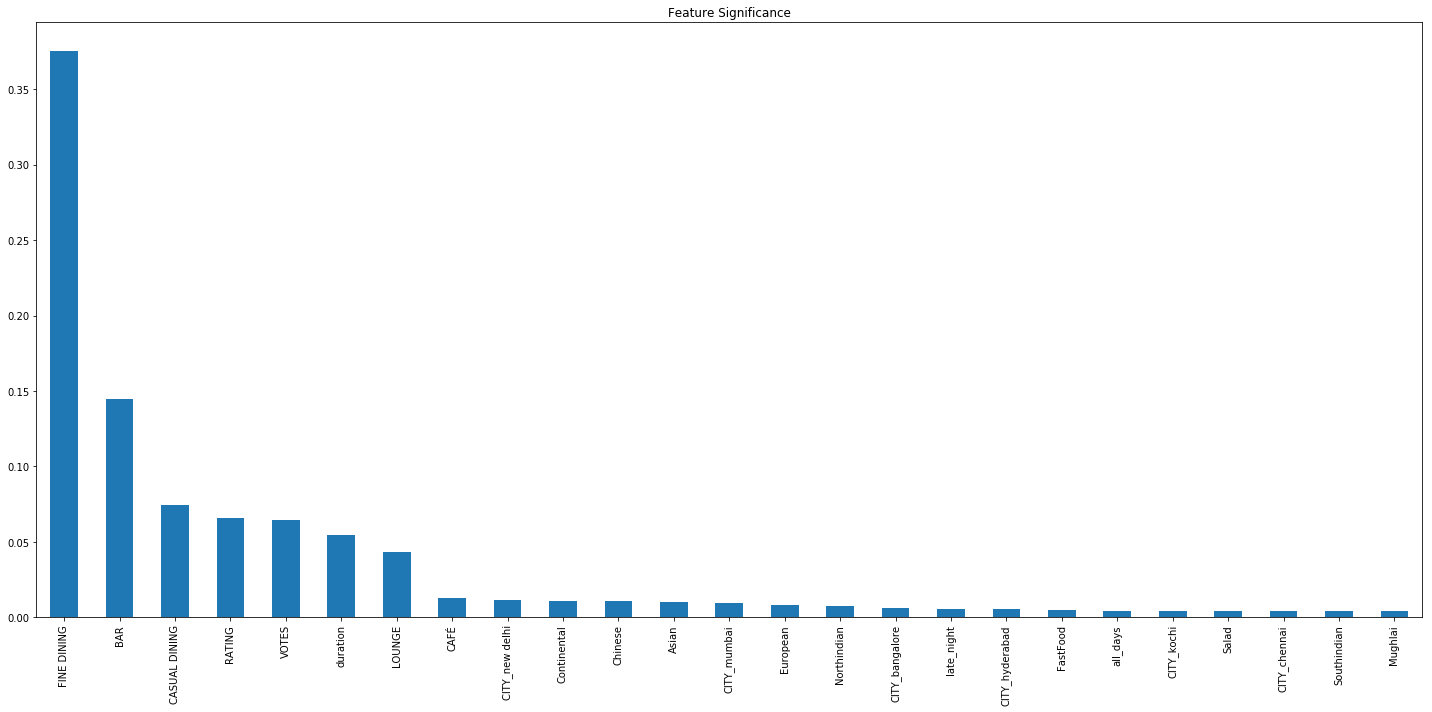

In [70]:
rf.fit(df_dummies_train, y.ravel())
# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(rf.feature_importances_, index = df_dummies_train.columns).sort_values(ascending=False)

plt.figure(figsize=(20, 10))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

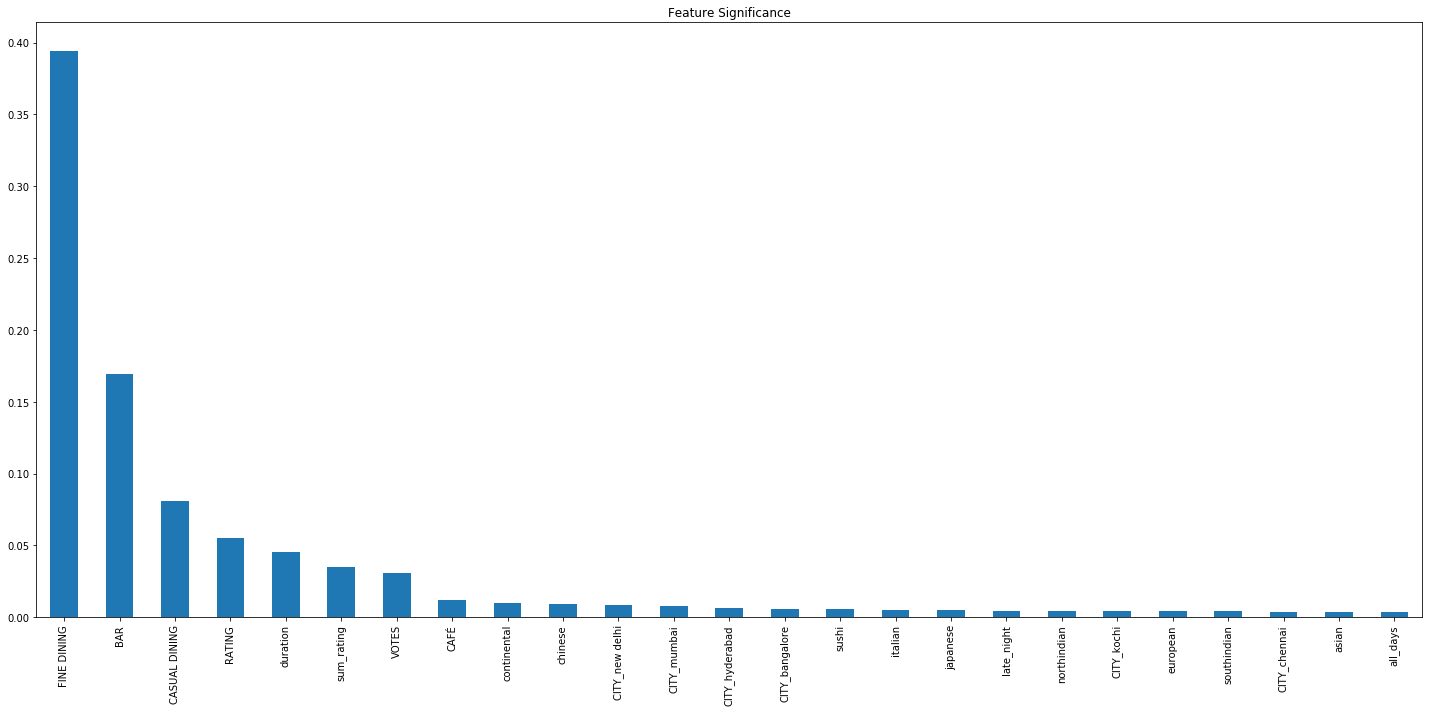

In [257]:
rf.fit(df_dummies_train, y.ravel())
# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(rf.feature_importances_, index = df_dummies_train.columns).sort_values(ascending=False)

plt.figure(figsize=(20, 10))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

# XGBoost

In [83]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(learning_rate =0.05,
        n_estimators=5000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.99,
        colsample_bytree=0.5,
        reg_alpha=1,
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [84]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 327.0732 (34.9732)



In [258]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 322.6303 (36.4569)



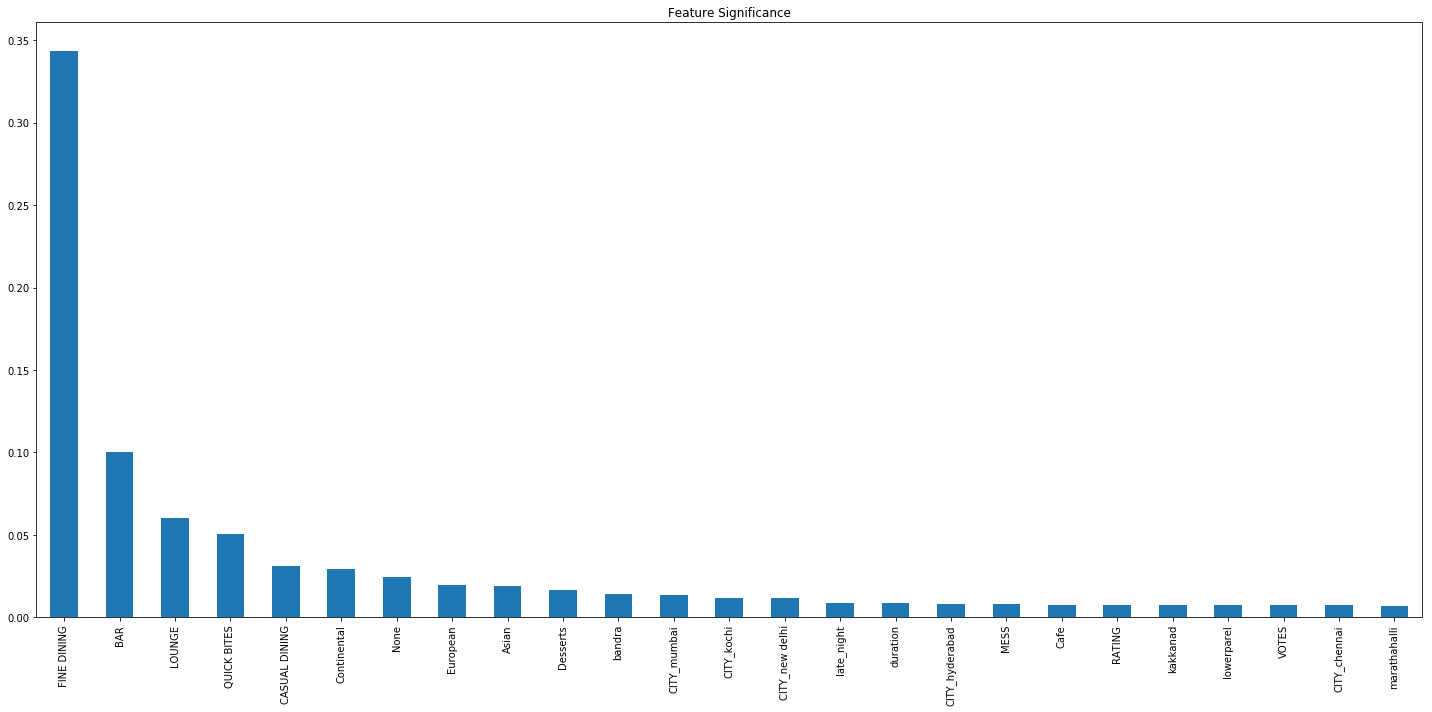

In [85]:
model_xgb.fit(df_dummies_train, y.ravel())
# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(model_xgb.feature_importances_, index = df_dummies_train.columns).sort_values(ascending=False)

plt.figure(figsize=(20, 10))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

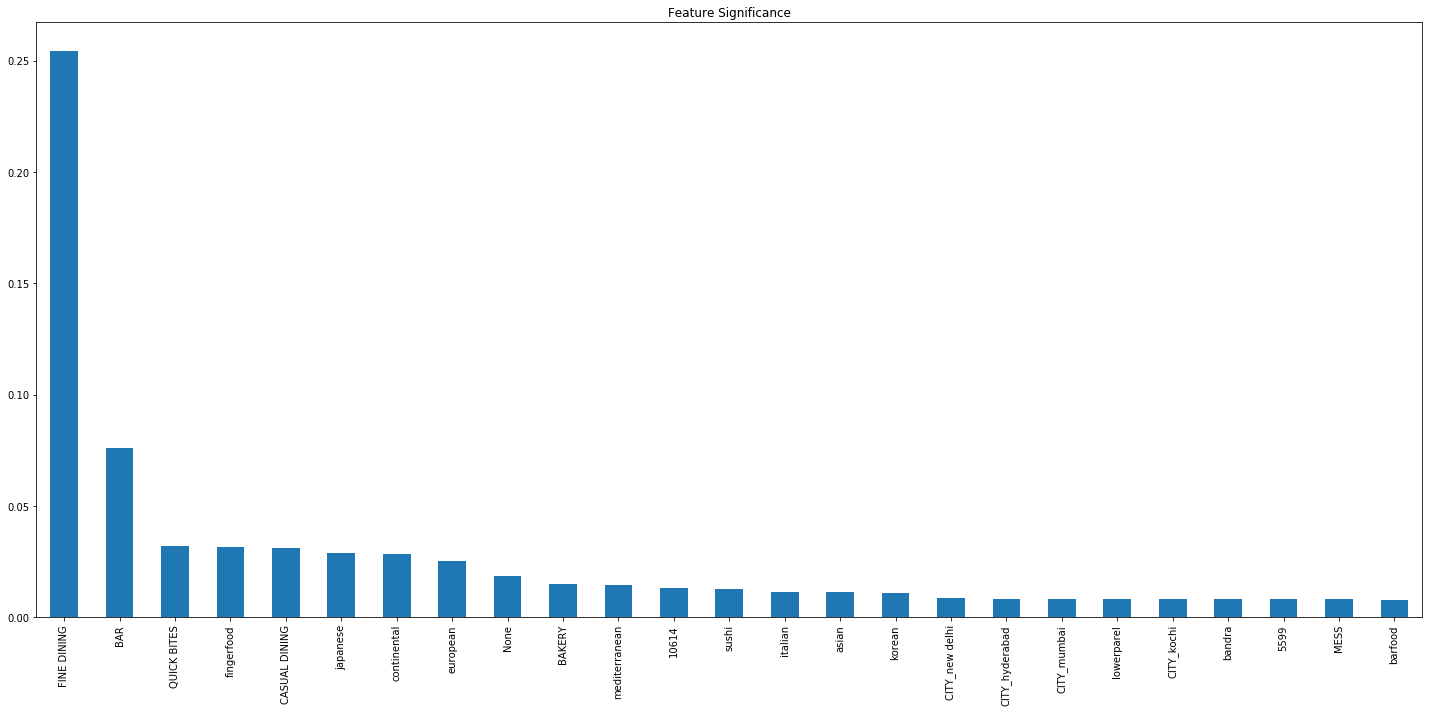

In [259]:
model_xgb.fit(df_dummies_train, y.ravel())
# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(model_xgb.feature_importances_, index = df_dummies_train.columns).sort_values(ascending=False)

plt.figure(figsize=(20, 10))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

# Output
I used stackedCVRegressor of LightGBM, Gradient Boosting, Random Forest and XGBoost to train on my final dataset.

In [60]:
y_pred = xgb1.predict(df_dummies_test)

In [61]:
res = pd.DataFrame(y_pred, columns=['COST'])
res.to_excel("output.xlsx", index=False)
res.head()

,COST
0,965.323425
1,371.976257
2,688.914062
3,294.791321
4,256.089417


# Hyperparameter tuning

In [96]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_dummies_train,y)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 1}, -101071.45722846888)

In [97]:
param_test1 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                                        param_grid = param_test1,n_jobs=4,iid=False, cv=5, scoring='neg_mean_squared_error')
gsearch1.fit(df_dummies_train,y)
gsearch1.best_params_, gsearch1.best_score_

({'gamma': 0.0}, -101071.45722846888)

In [104]:
param_test1 = {
    'colsample_bytree':[i/100.0 for i in range(50,55,2)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.99, colsample_bytree=0.8,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                                        param_grid = param_test1,n_jobs=4,iid=False, cv=5, scoring='neg_mean_squared_error')
gsearch1.fit(df_dummies_train,y)
gsearch1.best_params_, gsearch1.best_score_

({'colsample_bytree': 0.5}, -98765.82815135036)

In [109]:
param_test1 = {
    'reg_alpha':[0.5, 1, 5]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.99, colsample_bytree=0.5,
                                        nthread=4, scale_pos_weight=1, seed=27), 
                                        param_grid = param_test1,n_jobs=4,iid=False, cv=5, scoring='neg_mean_squared_error')
gsearch1.fit(df_dummies_train,y)
gsearch1.best_params_, gsearch1.best_score_

({'reg_alpha': 1}, -98604.5050531101)